<span style="margin-left:200px; font-size: 30px; font-style: italic; text-decoration: underline">Analysis of customer churns for Telco</span>

In [76]:
import pandas as pd
import numpy as np
import collections as cl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

from functools import partial

import itertools

%matplotlib inline

In [77]:
#Load original dataset
churn_original = pd.read_excel("Churn_original.xlsx")

In [78]:
churn_original = churn_original[churn_original["TotalCharges"] != " "]
churn_original["TotalCharges"] = churn_original["TotalCharges"].astype(float)

In [79]:
#Load dataset with categorical columns
churn = pd.read_excel("Churn.xlsx")
churn = churn[churn["TotalCharges"] != " "]
churn["TotalCharges"] = churn["TotalCharges"].astype(float)

# Data Preprocessing

### Normalization of the dataset

Having features with values in different ranges will influence the weights learned by the model. To remove this bias, we normalize the dataset using the statistical standardization.

In [80]:
sigmaTotalCharges = churn.TotalCharges.std()
sigmaMonthlyCharges = churn.TotalCharges.std()
sigmaTenure = churn.tenure.std()
meanTotalCharges = churn.TotalCharges.mean()
meanMonthlyCharges = churn.MonthlyCharges.mean()
meanTenure = churn.tenure.mean()

In [81]:
churn.TotalCharges = churn.TotalCharges.transform(lambda x: (x - meanTotalCharges) / sigmaTotalCharges)
churn.MonthlyCharges = churn.MonthlyCharges.transform(lambda x: (x - meanMonthlyCharges) / sigmaMonthlyCharges)
churn.tenure = churn.tenure.transform(lambda x: (x - meanTenure) / meanTenure)

### Distribution of features

We display box plots of non-categorical features to study their distribution. We set the option to show outliers to "True" to see if there are some.

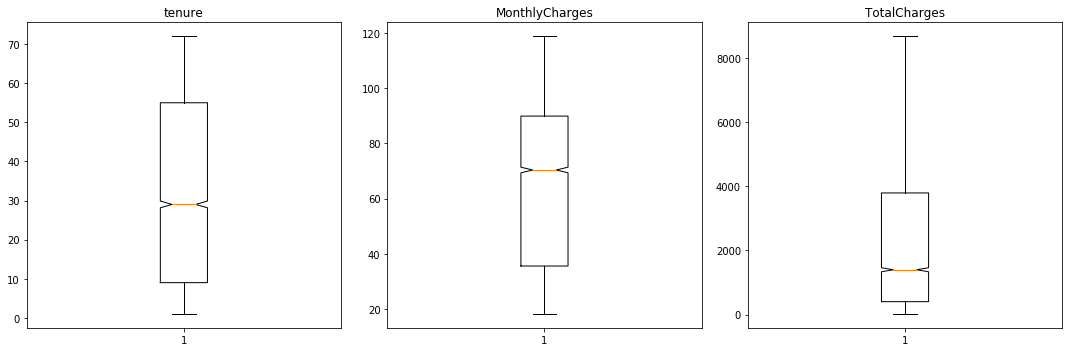

In [82]:
names = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i in range (len(names)):
    column_name = names[i]
    ax[i].set_title(column_name)
    ax[i].boxplot(np.array(churn_original[column_name]), 1, showfliers=True)
plt.tight_layout()

> *The main observation that we can make is the absence of any outlier. We can mention that the values of total charges are very sparse.*

### Correlations

Let's study the correlations between all the features in the dataset.

In [83]:
churn_corr = churn.corr()

corr = []
churn_tmp = churn.copy()
churn_tmp.drop("customerID", axis =1, inplace =  True)
i, j = 0, 0

for c1 in churn.drop("customerID", axis=1).columns:
    churn_tmp.drop(c1, axis =1, inplace =  True)
    for c2 in churn_tmp.columns:
        corr.append([round(churn_corr[c1].loc[c2],4),c1,c2])
        j = j+1
    i = i+1

corr_sorted = sorted(corr, reverse=True)
corr_sorted[:30]

[[1.0, 'TechSupportNoService', 'StreamingTVNoService'],
 [1.0, 'TechSupportNoService', 'StreamingMoviesNoService'],
 [1.0, 'StreamingTVNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineSecurityNoService', 'TechSupportNoService'],
 [1.0, 'OnlineSecurityNoService', 'StreamingTVNoService'],
 [1.0, 'OnlineSecurityNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineSecurityNoService', 'OnlineBackupNoService'],
 [1.0, 'OnlineSecurityNoService', 'DeviceProtectionnoService'],
 [1.0, 'OnlineBackupNoService', 'TechSupportNoService'],
 [1.0, 'OnlineBackupNoService', 'StreamingTVNoService'],
 [1.0, 'OnlineBackupNoService', 'StreamingMoviesNoService'],
 [1.0, 'OnlineBackupNoService', 'DeviceProtectionnoService'],
 [1.0, 'InternetServiceNo', 'TechSupportNoService'],
 [1.0, 'InternetServiceNo', 'StreamingTVNoService'],
 [1.0, 'InternetServiceNo', 'StreamingMoviesNoService'],
 [1.0, 'InternetServiceNo', 'OnlineSecurityNoService'],
 [1.0, 'InternetServiceNo', 'OnlineBackupNoService'],
 [1.0, 'I

> We observe that all the columns "No service" contain redundant information. Indeed, the columns with values "no Internet values" are equal to the column "Internet service". That's the same for the columns "Multiple lines" and "Phone service".
Thus, we can delete the columns 'TechSupportNoService', 'StreamingTVNoService', 'StreamingMoviesNoService', 'OnlineSecurityNoService', 'OnlineBackupNoService', 'DeviceProtectionnoService' and 'MultipleLinesNoService'*

In [84]:
#Deletion of redundant columns
churn.drop(['TechSupportNoService', 'StreamingTVNoService', 'StreamingMoviesNoService', 'OnlineSecurityNoService', 'OnlineBackupNoService', 'DeviceProtectionnoService', 'MultipleLinesNoService'], axis=1, inplace=True)

Now let's have a look at the new correlations without the redundant columns.

In [85]:
churn_corr = churn.corr()

corr = []
churn_tmp = churn.copy()
churn_tmp.drop("customerID", axis =1, inplace =  True)
i, j = 0, 0

for c1 in churn.drop("customerID", axis=1).columns:
    churn_tmp.drop(c1, axis =1, inplace =  True)
    for c2 in churn_tmp.columns:
        corr.append([round(churn_corr[c1].loc[c2],4),c1,c2])
        j = j+1
    i = i+1

corr_sorted = sorted(corr, reverse=True)
corr_sorted[:15]

[[0.8259, 'tenure', 'TotalCharges'],
 [0.7872, 'InternetServiceFiber', 'MonthlyCharges'],
 [0.6511, 'MonthlyCharges', 'TotalCharges'],
 [0.6297, 'StreamingTVYes', 'MonthlyCharges'],
 [0.6272, 'StreamingMoviesYes', 'MonthlyCharges'],
 [0.5638, 'tenure', 'ContractTwoYear'],
 [0.5381, 'StreamingTVNo', 'StreamingMoviesNo'],
 [0.5334, 'StreamingTVYes', 'StreamingMoviesYes'],
 [0.5229, 'DeviceProtectionYes', 'TotalCharges'],
 [0.5199, 'StreamingMoviesYes', 'TotalCharges'],
 [0.5157, 'StreamingTVYes', 'TotalCharges'],
 [0.5101, 'OnlineBackupYes', 'TotalCharges'],
 [0.4909, 'MultipleLinesYes', 'MonthlyCharges'],
 [0.4826, 'DeviceProtectionYes', 'MonthlyCharges'],
 [0.4701, 'OnlineSecurityNo', 'TechSupportNo']]

> *Some features such as "tenure" and "total charges", or "Fiber for internet" and "Monthly charges" are quite highly correlated.*

### Note about charges

In [86]:
print("The correlation between \"Total charges\" and the multiplication of the columns \"Monthly Charges\" and \"Tenure\" is:",round(churn.tenure.multiply(churn.MonthlyCharges).corr(churn.TotalCharges),7))

The correlation between "Total charges" and the multiplication of the columns "Monthly Charges" and "Tenure" is: 0.4266704


>*We observe that the column "Total Charges" is almost equal to the multiplication of the columns "Monthly Charges" and "Tenure". So we also have some redundant information with those 3 columns.*

# First analysis of the importance of features

### Analysis of categorical variables

In this part, we display in histograms the proportion of clients who churned for each feature. That will give us a first estimation of the importance of each feature.

Proportion of churns for each feature: (the light gray aera is the proportion of people who didn't churn)


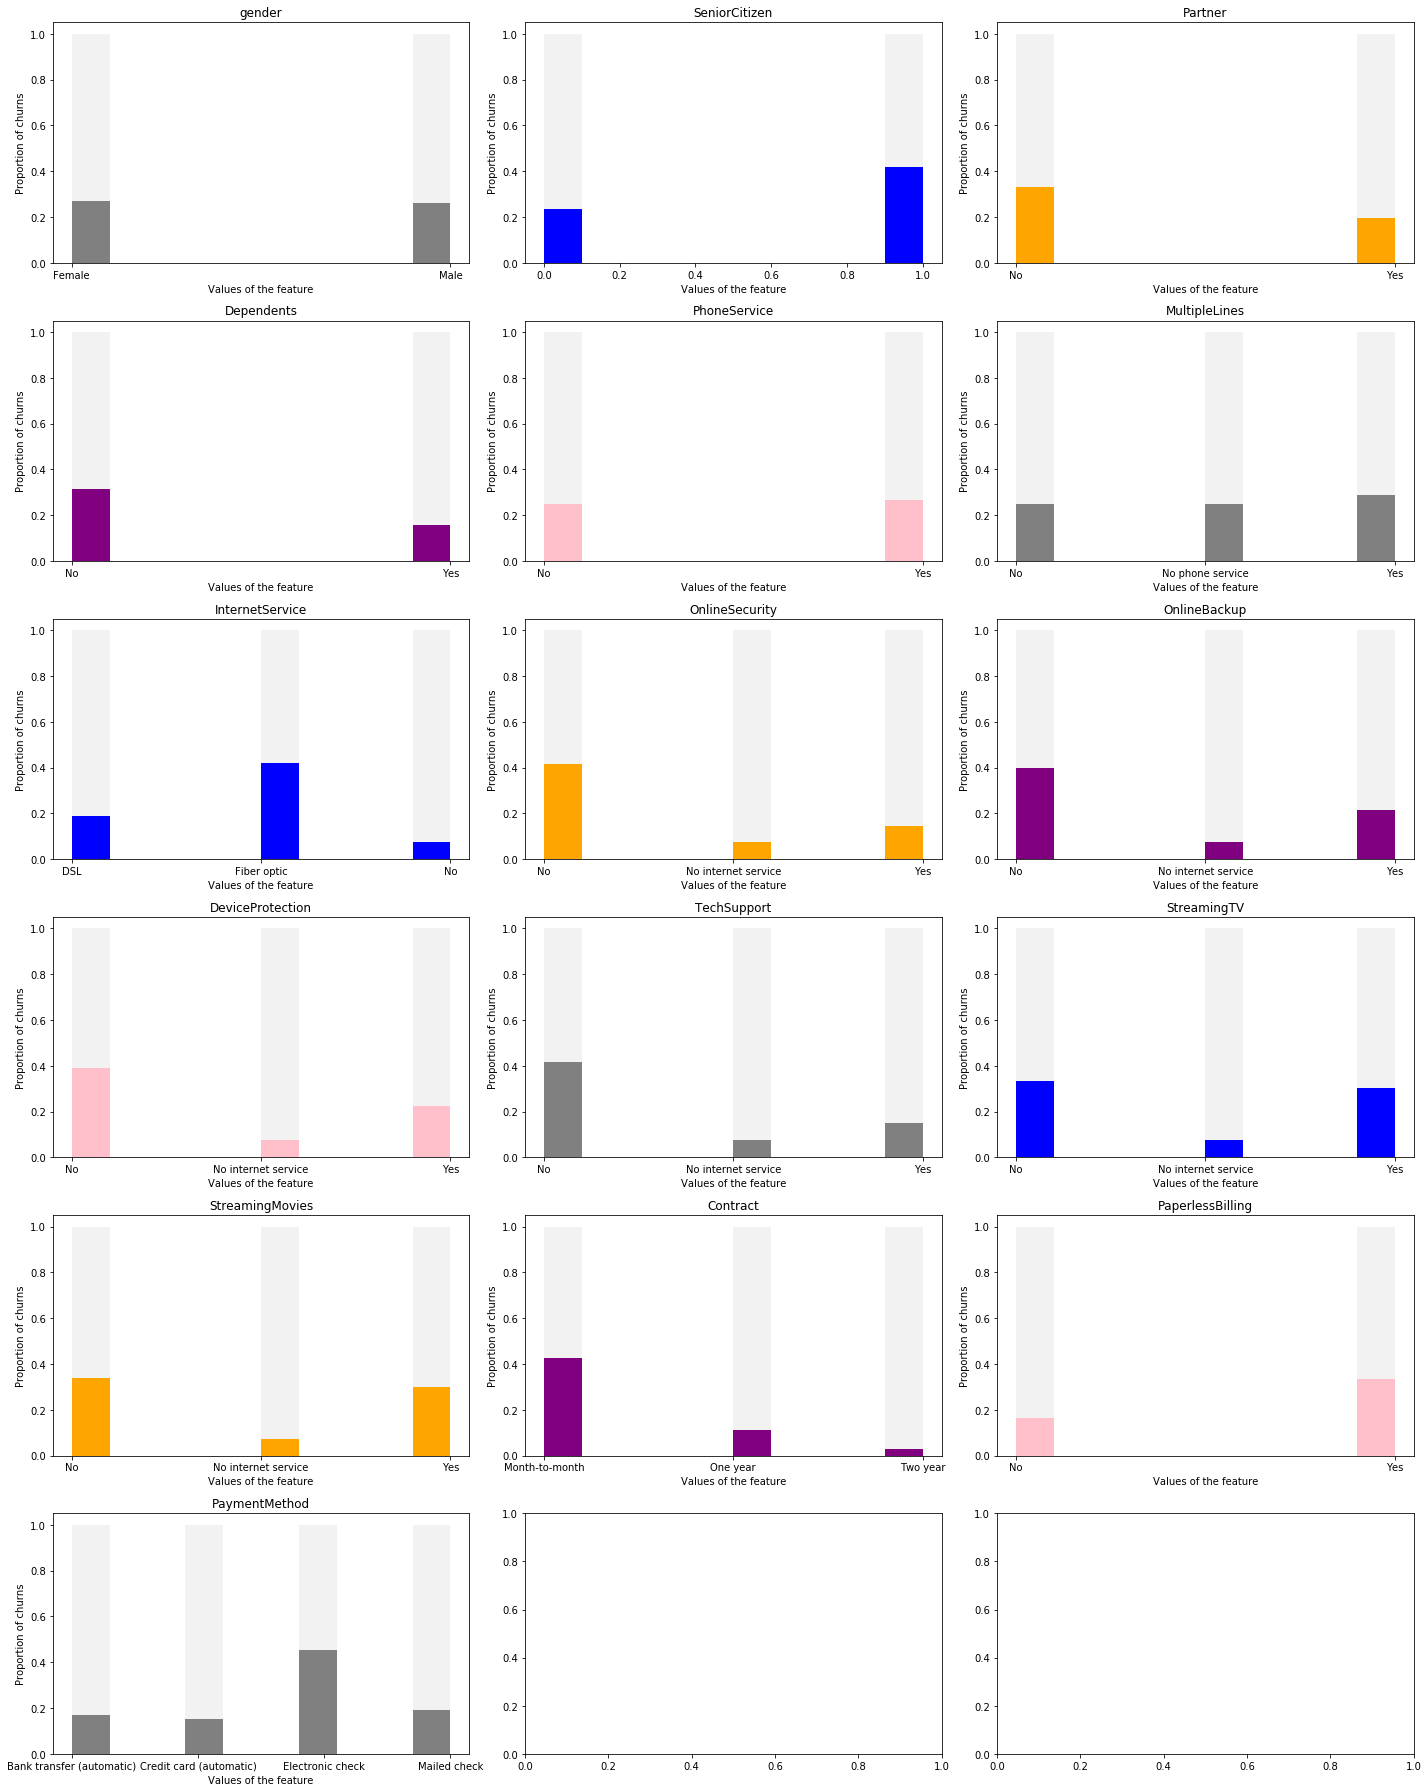

In [87]:
print("Proportion of churns for each feature: (the light gray aera is the proportion of people who didn't churn)")

columns = churn_original.drop("tenure", axis=1).columns[1:-3]
churned = churn_original[churn_original.Churn == "Yes"]

color = ["grey", "blue", "orange", "purple", "pink"]

fig, ax = plt.subplots(6, 3, figsize=(20,25))

for i in range(len(columns)):
    column_name = str(columns[i])
    
    weights = np.ones(churned.shape[0])
    weights1 = np.ones(churned.shape[0])

    for value in churned[column_name].value_counts().index.values.tolist():
        weights[churned[column_name] == value] = 1/churn_original[column_name].value_counts().loc[value]
        weights1[churned[column_name] == value] = 1/churned[column_name].value_counts().loc[value]
        
    ax[int(i/3)][i%3].hist(churned[column_name], color="#f2f2f2", weights=weights1)    
    ax[int(i/3)][i%3].hist(churned[column_name], color=color[i%5], weights=weights)
                          
    ax[int(i/3)][i%3].set_title(column_name)
    ax[int(i/3)][i%3].set_xlabel("Values of the feature")
    ax[int(i/3)][i%3].set_ylabel("Proportion of churns")
    
plt.tight_layout()


*We observe that some features seem to have very little influence on the churn, such as the gender, the multiple lines, the phone service.
Other features seem to be very important, like the tech support, the online security, the contract.<br><br>
3 payment methods look similar but the electronic check however leads to much more churns than the others.*

### Analysis of the tenure

In [88]:
tenure = churn_original[["tenure","Churn"]].copy()

In [89]:
tenure['tenure6'] = pd.Series(tenure.tenure <= 6, tenure.index)
tenure['tenure6_20'] = pd.Series(np.logical_and(tenure.tenure > 6, tenure.tenure <= 20), tenure.index)
tenure['tenure20_40'] = pd.Series(np.logical_and(tenure.tenure > 20, tenure.tenure <= 40), tenure.index)
tenure['tenure40_60'] = pd.Series(np.logical_and(tenure.tenure > 40, tenure.tenure <= 60), tenure.index)
tenure['tenure60'] = pd.Series(tenure.tenure > 60, tenure.index)
tenure['tenure_step'] = tenure['tenure6'] + 2 * tenure['tenure6_20'] + 3 * tenure['tenure20_40'] + 4 * tenure['tenure40_60'] + 5 * tenure['tenure60']
tenure_step_churn = np.array(tenure[tenure.Churn == 'Yes'].tenure_step)
tenure_step_not_churn = np.array(tenure[tenure.Churn == 'No'].tenure_step)
churn_graph = [tenure_step_churn, tenure_step_not_churn]

Text(0.5,1,'Number of clients who churn or not for each range of Tenure')

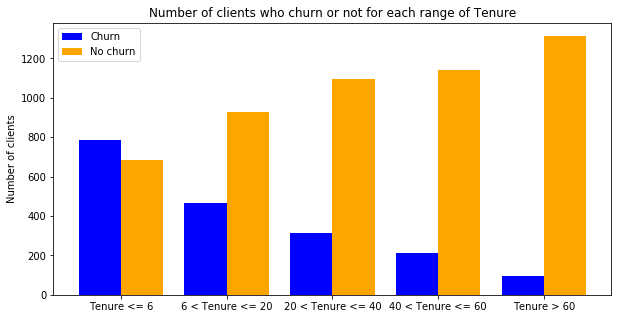

In [90]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

colors = ['blue', 'orange']

ax.hist(churn_graph, 5, histtype='bar', label=["Churn", "No churn"],  color=colors)
ax.legend()
ax.set_xticks([1.4,2.2,3,3.8,4.6])
ax.set_xticklabels(["Tenure <= 6","6 < Tenure <= 20","20 < Tenure <= 40","40 < Tenure <= 60","Tenure > 60"])
ax.set_ylabel("Number of clients")
ax.set_title("Number of clients who churn or not for each range of Tenure")

*We observe that people who are clients since a long time are much less likely to churn.*

### Analysis of the monthly charges

In [91]:
charges = churn_original[["MonthlyCharges","Churn"]].copy()

In [92]:
charges['charges20_40'] = pd.Series(np.logical_and(charges.MonthlyCharges > 20, charges.MonthlyCharges <= 40), charges.index)
charges['charges40_60'] = pd.Series(np.logical_and(charges.MonthlyCharges > 40, charges.MonthlyCharges <= 60), charges.index)
charges['charges60_80'] = pd.Series(np.logical_and(charges.MonthlyCharges > 60, charges.MonthlyCharges <= 80), charges.index)
charges['charges80_100'] = pd.Series(np.logical_and(charges.MonthlyCharges > 80, charges.MonthlyCharges <= 100), charges.index)
charges['charges100_120'] = pd.Series(np.logical_and(charges.MonthlyCharges > 100, charges.MonthlyCharges <= 120), charges.index)

charges['charges_step'] = charges['charges20_40'] + 2 * charges['charges40_60'] + 3 * charges['charges60_80'] + 4 * charges['charges80_100'] + 5 * charges['charges100_120']
charges_step_churn = np.array(charges[charges.Churn == 'Yes'].charges_step)
charges_step_not_churn = np.array(charges[charges.Churn == 'No'].charges_step)
churn_graph = [charges_step_churn, charges_step_not_churn]

Text(0.5,1,'Number of clients who churn or not for each range of Monthly Charges')

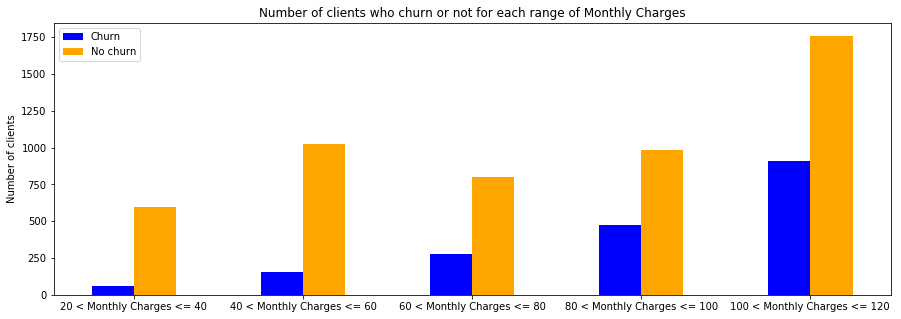

In [93]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

colors = ['blue', 'orange']

ax.hist(churn_graph, 5, histtype='bar', label=["Churn", "No churn"],  color=colors, rwidth=0.5)
ax.legend()
ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
ax.set_xticklabels(["20 < Monthly Charges <= 40","40 < Monthly Charges <= 60","60 < Monthly Charges <= 80","80 < Monthly Charges <= 100","100 < Monthly Charges <= 120"])
ax.set_ylabel("Number of clients")
ax.set_title("Number of clients who churn or not for each range of Monthly Charges")

>*We see that the more significant the charges are, the more likely the clients are to churn. But they are also more likely not to churn with higher monthly charges. With this first analysis, the dependency between monthly charges and the churns looks less significant than for the tenure.*

>*As we have seen, the total charges are the multiplication of the monthly charges with the tenure. So adding an histogram for this feature won't add much information.*

# Machine learning

### Accurracy of algorithms

Now, we use machine learning to try to predict as well as possible the churns. <br>
We start with an analysis of the most efficient algorithm of machine learning in classification. We try the logistic regression and the random forest (one version that returns probabilities and one that returns directly the class).<br>
Then, we display the confusion matrix and we add the average accurracy for each algorithm.

In [94]:
#function taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest')#, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [95]:
def build_confusion_matrix(labels, prediction, show_graph, title='Confusion matrix'):
    cm = confusion_matrix(labels, prediction)
    (tn, fp, fn, tp) = cm.ravel()
    if show_graph == True:
        plt.figure()
        print(cm)
        plot_confusion_matrix(cm, ["No Churn", "Churn"], normalize=False, title=title)
    return cm.ravel()

In [96]:
train = churn.iloc[0:6000].drop("customerID", axis=1)
test =  churn.iloc[6001:].drop("customerID", axis=1)

In [97]:
def predict_random_forest(train, test):
    classifier = RandomForestClassifier()
    classifier.fit(train.drop("Churn", axis=1), train.Churn)
    predicted_churn = classifier.predict(test.drop("Churn", axis=1))
    classifier_score = classifier.score(test.drop("Churn", axis=1), test.Churn)
    cm = build_confusion_matrix(test.Churn, predicted_churn, True, title="Random Forest")
    return (classifier_score, classifier.predict),classifier.feature_importances_

In [98]:
def random_forest_proba_classifier(x, classifier, split_value):
    prediction = classifier.predict_proba(x)
    prediction[prediction <= split_value] = 0
    prediction[prediction > split_value] = 1
    return prediction

def predict_random_forest_proba(train, test):
    classifier = RandomForestClassifier()
    classifier.fit(train.drop("Churn", axis=1), train.Churn)
    predicted_churn = classifier.predict_proba(test.drop("Churn", axis=1))
    prediction = predicted_churn.T[1].T
    c = cl.Counter(prediction)
    a = sorted(list(c.items()))
    keys = np.array(a).T[0].T
    values = np.array(a).T[1].T
    proportion = churn.Churn.value_counts()

    counter = 0
    index=0
    while counter < (proportion[1] * sum(values) / (proportion [0] + proportion[1])):
        index += 1
        counter += values[index]
    prediction[prediction <= keys[index]] = 0
    prediction[prediction > keys[index]] = 1
    matched = (prediction - np.array(test.Churn) == 0)
    score = (prediction - np.array(test.Churn) == 0).sum()/len(test)
    cm = build_confusion_matrix(test.Churn, prediction, True, title="Random Forest with Probabilities")
    return (score, cm, partial(random_forest_proba_classifier, classifier=classifier, split_value=keys[index]))

In [99]:
def predict_log_reg(train, test):
    X_train = train.drop("Churn", axis=1)
    X_test = test.drop("Churn", axis=1)
    y_train = train.Churn
    y_test = test.Churn
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train,y_train)
    pred = logisticRegr.predict(X_test)
    score = accuracy_score(y_test, pred)
    cm = build_confusion_matrix(y_test, pred, True, title="Logistic regression")
    return (score, cm, logisticRegr.predict)

[[601  54]
 [129  95]]


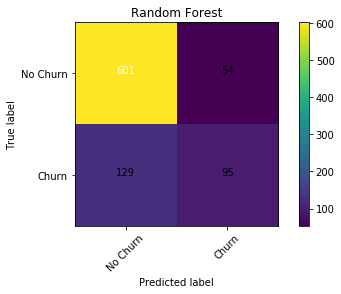

[[453 202]
 [ 51 173]]


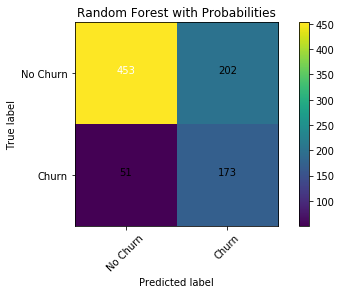

[[586  69]
 [106 118]]


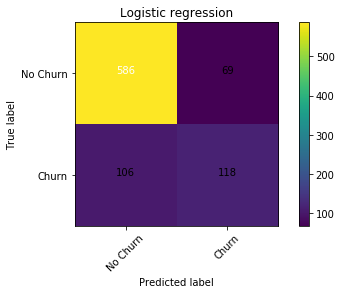

[[582  61]
 [134 102]]


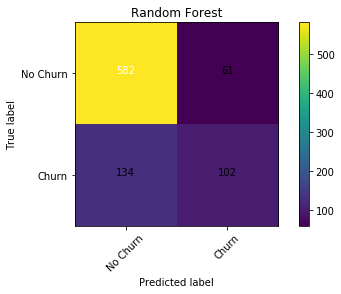

[[457 186]
 [ 46 190]]


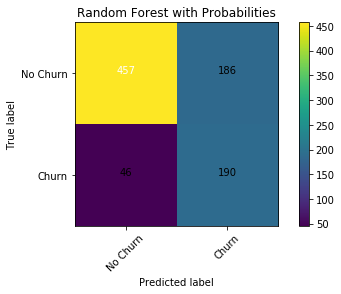

[[579  64]
 [ 98 138]]


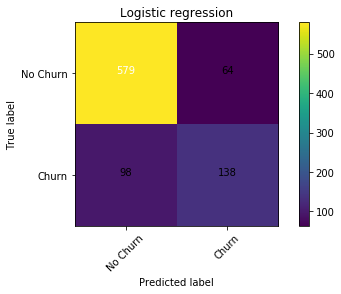

[[574  77]
 [135  93]]


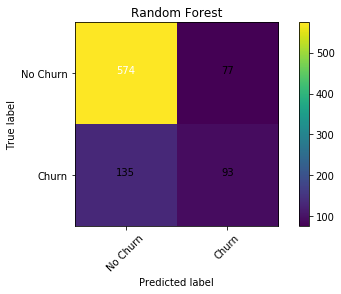

[[511 140]
 [ 82 146]]


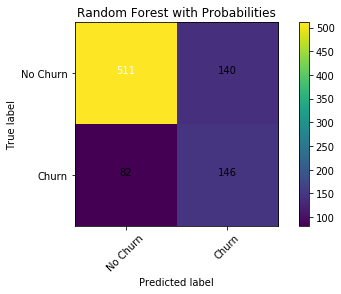

[[574  77]
 [102 126]]


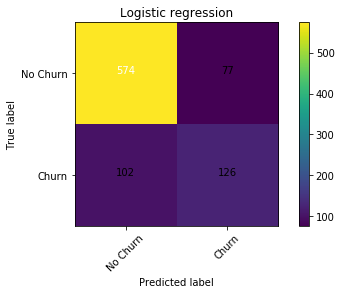

[[583  67]
 [123 106]]


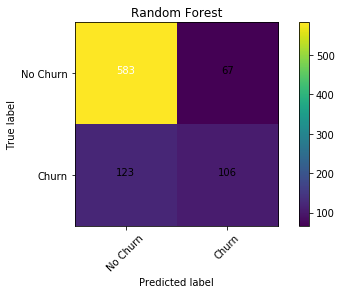

[[504 146]
 [ 77 152]]


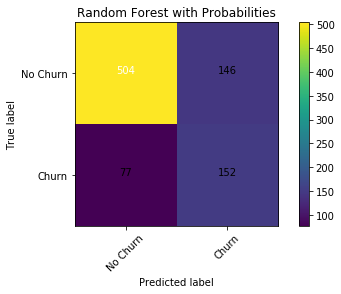

[[582  68]
 [104 125]]


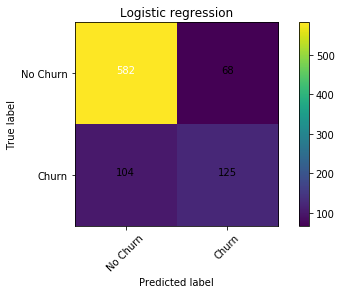

[[571  73]
 [145  90]]


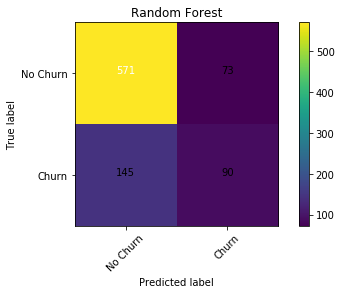

[[483 161]
 [ 87 148]]


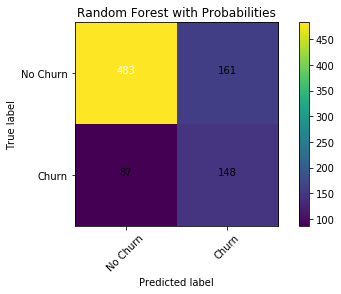

[[576  68]
 [110 125]]


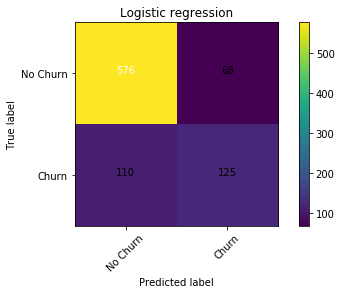

[[584  64]
 [133  98]]


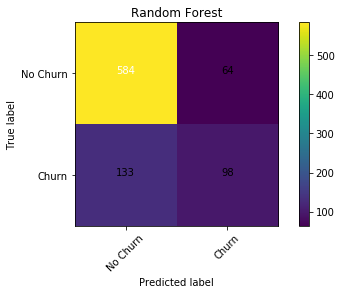

[[501 147]
 [ 76 155]]


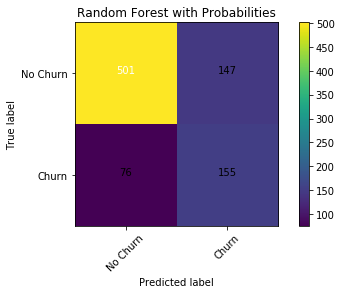

[[573  75]
 [ 95 136]]


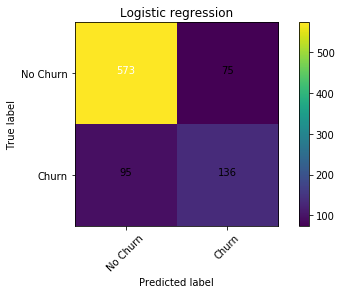

[[580  56]
 [134 109]]


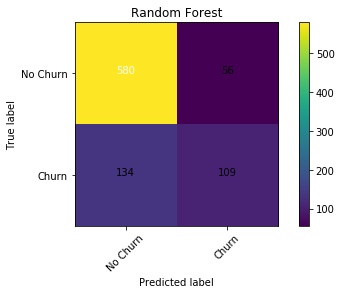

[[464 172]
 [ 69 174]]


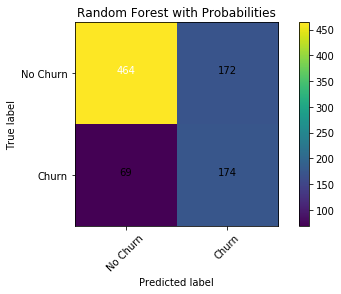

[[577  59]
 [112 131]]


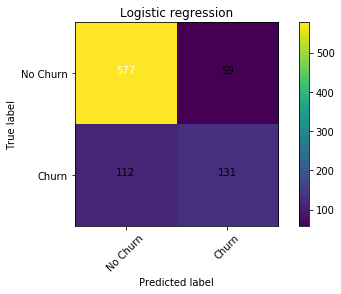

[[577  59]
 [132 111]]


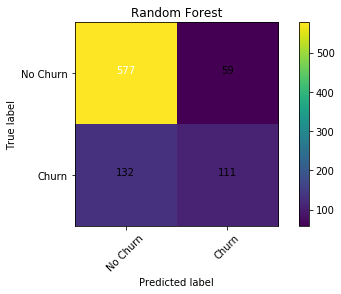

[[459 177]
 [ 63 180]]


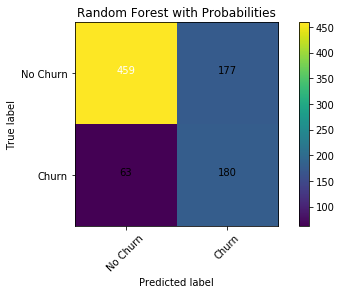

[[578  58]
 [114 129]]


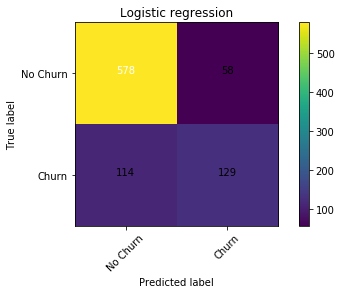

In [100]:
def mean_score(x):
    return np.array(x).T[0].sum() / len(x)

churn.sample(frac=1)
n = 8
chunk_size = int(len(churn) / n)
random_forest = []
random_forest_proba = [] 
feature_importance_forest = []
log_reg = []
for i in range(n):
    test_low = i * chunk_size
    test_high = (i + 1) * chunk_size
    train_index = list(range(len(churn)))
    for j in range(test_low, test_high):
        train_index.remove(j)
    train = churn.iloc[train_index].drop("customerID", axis=1)
    test = churn.iloc[test_low:test_high].drop("customerID", axis=1)
    #random_forest.append(predict_random_forest(train, test))
    pred, importance =predict_random_forest(train, test)
    random_forest.append(pred)
    feature_importance_forest.append(importance)
    random_forest_proba.append(predict_random_forest_proba(train, test))
    log_reg.append(predict_log_reg(train, test))

In [101]:
(mean_score(random_forest), mean_score(random_forest_proba), mean_score(log_reg))

(0.7758816837315131, 0.7323663253697383, 0.8038964732650741)

>*We observe that logistic regression gives the best result of accurracy for our study. The confusion matrix allow to have a quick look at the results of every algorithm.*

### Inportance of each feature towards Churns

Now we use a function provided by scikit learn with random forest, which allows to estimate the importance of each feature to predict the churn. That will be a key element to determine the main fields in which Telco could invest.

In [102]:
# Calculation of the mean of the feature importance 
feature_imp_forest = []
for j in range(0,len(feature_importance_forest[0])):
    feature_imp_forest.append(sum(i[j] for i in feature_importance_forest)/8)

In [103]:
names = churn.drop(["Churn","customerID"],axis = 1).columns
print("Features sorted by their score:")
sorted(zip(map(lambda x: x, feature_imp_forest),names), reverse=True)

Features sorted by their score:


[(0.1715896603975821, 'TotalCharges'),
 (0.15183361775812582, 'MonthlyCharges'),
 (0.14699131210990296, 'tenure'),
 (0.04951839473385376, 'ContractMonth'),
 (0.0356149376395382, 'TechSupportNo'),
 (0.03219308966310274, 'OnlineSecurityNo'),
 (0.02825646362941539, 'gender'),
 (0.02682596217171447, 'PaymentMethodElectronic'),
 (0.025290810100008734, 'PaperlessBilling'),
 (0.024399124534179327, 'InternetServiceFiber'),
 (0.02375712368010809, 'Partner'),
 (0.02161418271671671, 'OnlineBackupNo'),
 (0.02081765278489449, 'SeniorCitizen'),
 (0.020090627654563764, 'Dependents'),
 (0.01755420726582661, 'DeviceProtectionNo'),
 (0.015772239993893957, 'ContractTwoYear'),
 (0.014163481908548943, 'MultipleLinesNo'),
 (0.013152935968436776, 'MultipleLinesYes'),
 (0.012967997834532924, 'PaymentMethodCredit'),
 (0.012927617791152084, 'InternetServiceDSL'),
 (0.012302701498835155, 'PaymentMethodBank'),
 (0.011977530615385788, 'OnlineSecurityYes'),
 (0.011774689402495151, 'StreamingMoviesYes'),
 (0.0117421

In [104]:
l = sorted(zip(map(lambda x: x, feature_imp_forest),names), reverse=True)
imp = [i[0] for i in l]
names_ = [i[1] for i in l]

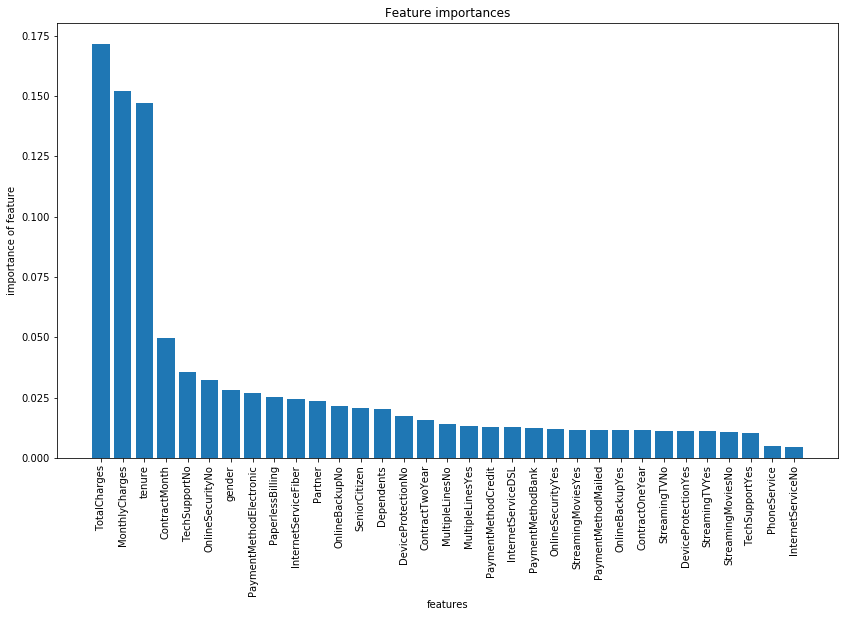

In [105]:
fig = plt.figure(figsize=(14,8))
plt.title("Feature importances")
plt.xlabel("features")
plt.ylabel("importance of feature")
plt.bar(range(len(names_)),imp)
plt.xticks(range(len(names_)), names_,rotation='vertical')
plt.show()

>*The most important features of the dataset are the totalcharges, the monthly charges and the tenure. As predicted before, the tenure effectively has a great influence on customer’s behaviour.  Some other features appeared to be relatively important:  the contract month-to-month, the ”no” online security, the ”no” tech support, the fiber optic internet and the electronic payment method.  These final results perfectly correspond to the predictions done in the first analysis.*